In [1]:
import glob

images = glob.glob('../facenet/lfw_mtcnnpy_160/Arnold_Schwarzenegger/*')
len(images)

42

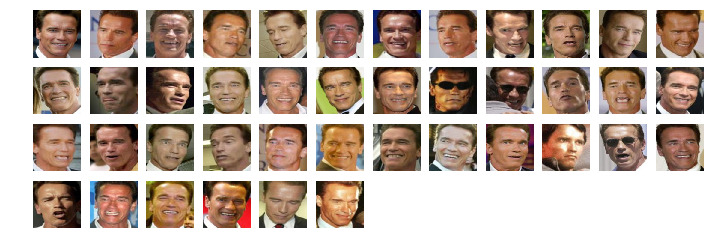

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 4))
for i, image in enumerate(images):
    image = cv2.imread(image)[:, :, ::-1]
    plt.subplot(4, 12, i+1)
    plt.imshow(image)
    plt.axis('off')

In [3]:
import align.detect_face as FaceDet
import tensorflow as tf

graph = tf.Graph()
with graph.as_default():
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
    sess = tf.Session(config=tf.ConfigProto(
        gpu_options=gpu_options, log_device_placement=False))
    with sess.as_default():
        pnet, rnet, onet = FaceDet.create_mtcnn(sess, None)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [4]:
def detect(img):
    """
    img: rgb 3 channel
    """
    minsize = 20  # minimum size of face
    threshold = [0.6, 0.7, 0.7]  # three steps's threshold
    factor = 0.709  # scale factor

    bounding_boxes, _ = FaceDet.detect_face(
        img, minsize, pnet, rnet, onet, threshold, factor)
    num_face = bounding_boxes.shape[0]
    assert num_face == 1, num_face
    bbox = bounding_boxes[0][:4]  # xy,xy

    margin = 32
    x0 = np.maximum(bbox[0] - margin // 2, 0)
    y0 = np.maximum(bbox[1] - margin // 2, 0)
    x1 = np.minimum(bbox[2] + margin // 2, img.shape[1])
    y1 = np.minimum(bbox[3] + margin // 2, img.shape[0])
    x0, y0, x1, y1 = bbox = [int(k + 0.5) for k in [x0, y0, x1, y1]]
    cropped = img[y0:y1, x0:x1, :]
    scaled = cv2.resize(cropped, (160, 160))
    return scaled, bbox

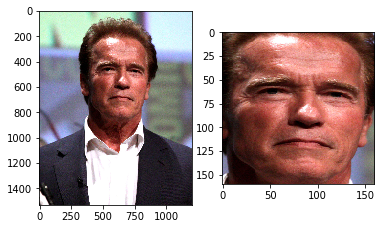

In [5]:
img = cv2.imread('data/Arnold_Schwarzenegger.jpg')[:, :, ::-1]
face, bbox = detect(img)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(face)

In [6]:
from keras.models import load_model
import keras.backend as K

K.set_learning_phase(0)

model = load_model('model/facenet_keras.h5')

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x),
                                           axis=axis, keepdims=True), epsilon))
    return output

In [8]:
embs = []

for i, image in enumerate(images):
    image = cv2.imread(image)[:, :, ::-1]
    face, bbox = detect(img)

    face2 = (face - 127.5) / 128.0

    emb = l2_normalize(model.predict(np.expand_dims(face2, axis=0)))
    embs.append(emb)

In [9]:
avg_emb = np.mean(embs, axis=0)

## Test

In [10]:
pos = np.random.choice(images)
pos = cv2.imread(pos)[:, :, ::-1]
pos2 = (pos - 127.5) / 128.0
emb_pos = model.predict(np.expand_dims(pos2, axis=0))
emb_pos = l2_normalize(emb_pos)

0.8185947


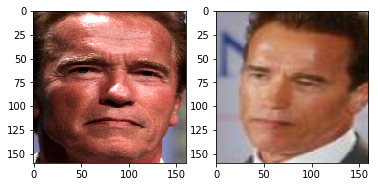

In [11]:
print(np.linalg.norm(emb_pos - avg_emb))
plt.subplot(1, 2, 1)
plt.imshow(face)
plt.subplot(1, 2, 2)
plt.imshow(pos)

In [12]:
neg = cv2.imread('data/Trump.jpg')[:, :, ::-1]
neg, bbox = detect(neg)
neg2 = (neg - 127.5) / 128.0
emb_neg = model.predict(np.expand_dims(neg2, axis=0))
emb_neg = l2_normalize(emb_neg)

1.2684958


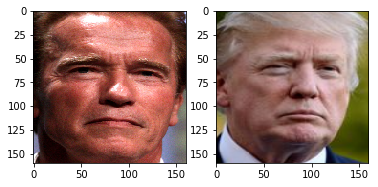

In [13]:
print(np.linalg.norm(emb_neg - avg_emb))
plt.subplot(1, 2, 1)
plt.imshow(face)
plt.subplot(1, 2, 2)
plt.imshow(neg)

## example from https://github.com/ppwwyyxx/Adversarial-Face-Attack

In [14]:
pos = cv2.imread('data/JCJ-to-Schwarzenegger.png')[:, :, ::-1]
pos, bbox = detect(pos)
pos2 = (pos - 127.5) / 128.0
emb_pos = model.predict(np.expand_dims(pos2, axis=0))
emb_pos = l2_normalize(emb_pos)

0.8330018


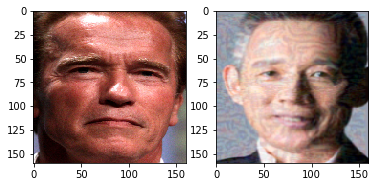

In [15]:
print(np.linalg.norm(emb_pos - avg_emb))
plt.subplot(1, 2, 1)
plt.imshow(face)
plt.subplot(1, 2, 2)
plt.imshow(pos)

In [16]:
neg = cv2.imread('data/JCJ.png')[:, :, ::-1]
neg, bbox = detect(neg)
neg2 = (neg - 127.5) / 128.0
emb_neg = model.predict(np.expand_dims(neg2, axis=0))
emb_neg = l2_normalize(emb_neg)

1.4131564


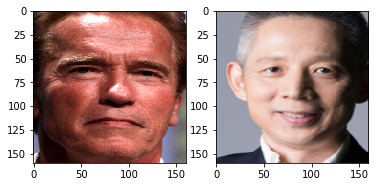

In [17]:
print(np.linalg.norm(emb_neg - avg_emb))
plt.subplot(1, 2, 1)
plt.imshow(face)
plt.subplot(1, 2, 2)
plt.imshow(neg)

## Adversarial Attack

In [18]:
# import foolbox
# import keras

# keras.backend.set_learning_phase(0)
# fmodel = foolbox.models.KerasModel(model, bounds=(0, 255), predicts='logits')
# attack = foolbox.attacks.PGD(fmodel)